good luck

## HW 3 - Part 2
**Submitted by Rie Ruash 213035199**

## Set-up:

In [2]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import shutil
# %matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation, Input, Lambda
from keras.optimizers import SGD

# for part 2
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# from keras.models import Model

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils

In [4]:
import scipy.io
from skimage.transform import resize

In [5]:
# for yolov5
import torch
from IPython.display import Image, clear_output  # to display images

In [6]:
from keras.applications.densenet import DenseNet201

## Part 2:

### Loading the dataset of flowers:

In [7]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
!tar -xzf 102flowers.tgz;

--2023-07-22 14:24:11--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-07-22 14:24:12--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  13.8MB/s    in 25s     

2023-07-22 14:24:39 (13.3 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]

--2023-07-22 14:24:39--  https://www.robots.ox.ac.uk/~vgg/data/flowe

In [8]:
# paths - change the following if needed!
image_labels_mat = '/content/imagelabels.mat'
source_102_images= '/content/jpg'

In [9]:
def read_from_dir_to_sets(files, s_dir, target_base, set_n, labels):
  for file_n in files:
    index = int((file_n.split('.')[0]).split('_')[-1]) - 1
    target_dir = target_base + '/' + set_n + '/' + str(labels[index])
    if not os.path.isdir(target_dir):
        os.mkdir(target_dir)
    shutil.copy(s_dir + '/' + file_n, target_dir + '/' + file_n)

In [ ]:
RANDOM_SPLIT_TIMES = 2

mat = scipy.io.loadmat(image_labels_mat)
images_files = os.listdir(source_102_images)
images_files = sorted(images_files)

labels = mat['labels'][0].tolist()
# print(images_files)
# print(labels)

In [ ]:
for i in range(RANDOM_SPLIT_TIMES):
  shutil.rmtree(f'data_split{i}', ignore_errors=True)
  os.mkdir(f'data_split{i}')
  os.mkdir(f'data_split{i}/train')
  os.mkdir(f'data_split{i}/val')
  os.mkdir(f'data_split{i}/test')

  # randomly splitting the data to train 50%, validation 25% and test 25%
  x_train, x_valid_test, y_train, y_valid_test = train_test_split(images_files,labels, test_size = 0.5, stratify=labels)
  x_valid, x_test, y_valid, y_test  = train_test_split(x_valid_test,y_valid_test ,test_size = 0.5, stratify=y_valid_test)

  # print(f'split{i}:')
  # print('train:',x_train)
  # print(y_train)
  # print('valid:',x_valid)
  # print(y_valid)
  # print('test:',x_test)
  # print(y_test)

  # copying to the directories we created - each label images are in different sub-folder
  read_from_dir_to_sets(x_train, source_102_images, f'data_split{i}', 'train', labels)
  read_from_dir_to_sets(x_valid, source_102_images, f'data_split{i}', 'val', labels)
  read_from_dir_to_sets(x_test, source_102_images, f'data_split{i}', 'test', labels)

In [12]:
labels[5583] # image 05584

32

### base transfer learning functions and variables in keras:

In [14]:
# basic variables:
batch_size = 32
classes_n = 102
image_width = 256
image_height = 256

In [15]:
# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.2,
                                    rotation_range=40)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# defining custom callback that will 'record' the accuracy and cross entropy
# loss through the epochs for the test data that will be called at the end of each epoch

class customTestEpochCallback(keras.callbacks.Callback):
    def __init__(self, acc_arr_test, loss_arr_test, test_set_gen):
        super().__init__()
        self.loss_arr_test = loss_arr_test
        self.acc_arr_test = acc_arr_test
        self.data_test = test_set_gen

    def on_epoch_end(self, epoch, logs=None):
        print("\nTesting epoch #", epoch+1)
        loss_t, acc_t = self.model.evaluate(self.data_test,verbose=1)  # verbose=1 so we will see progress bar
        self.loss_arr_test.append(loss_t)
        self.acc_arr_test.append(acc_t)

In [59]:
def training_procedure(model_type, split_num, acc_arr,loss_arr ,num_classes=102):

    # Through flow_from_directory - we create an array of images that can be used for training.
    training_set = train_datagen.flow_from_directory(f'{split_num}/train',
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)
    # print('training_set_len: ', len(training_set))
    validation_set = validation_datagen.flow_from_directory(f'{split_num}/val',
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

    test_set = test_datagen.flow_from_directory(f'{split_num}/test',
                                                target_size = (256, 256),
                                                batch_size = 128,
                                                class_mode = 'categorical',
                                                shuffle = False)

    # building the model:
    keras.backend.clear_session()

    for layer in model_type.layers:
        layer.trainable = False # freezing layers

    print(model_type.output_shape, model_type.output_shape[-1])
    model_to_fit = Sequential([model_type,
                               Flatten(),
                               Dense(model_type.output_shape[-1],activation="relu"),
                               Dense(classes_n, activation='softmax')
                              ]) # keras.layers.GlobalAveragePooling2D(),

    model_to_fit.summary(expand_nested=True)

    model_to_fit.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_to_fit = model_to_fit.fit(training_set, validation_data=validation_set, epochs=40 , steps_per_epoch=50,
                                    callbacks=[customTestEpochCallback(test_set_gen=test_set, acc_arr_test=acc_arr, loss_arr_test=loss_arr)])

    return model_to_fit

plotting acc and loss:

In [53]:
def plots_acc_loss(model_to_fit, acc_arr_t, loss_arr_t):

    # loss
    plt.plot(model_to_fit.history['loss'], label='train loss')
    plt.plot(model_to_fit.history['val_loss'], label='val loss')
    plt.plot(loss_arr_t, label='test loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(model_to_fit.history['accuracy'], label='train acc')
    plt.plot(model_to_fit.history['val_accuracy'], label='val acc')
    plt.plot(acc_arr_t, label='test acc')
    plt.legend()
    plt.show()

### VGG19:

In [62]:
IMG_SIZE = [image_height,image_width]

# creating a VGG19 model, and removing the last layer that is classifying 1000 images.
# This will be replaced with images classes we have.
vgg19 = VGG19(input_shape=IMG_SIZE + [3], weights="imagenet", include_top=False)

#### split 0

In [63]:
# metrics for the test set plots
vgg19_split0_acc = []
vgg19_split0_loss= []

# note: split_num path - change if needed!
vgg19_0_fitted = training_procedure(model_type=vgg19, split_num='/content/data_split0', acc_arr=vgg19_split0_acc, loss_arr=vgg19_split0_loss)

Found 4094 images belonging to 102 classes.
Found 2047 images belonging to 102 classes.
Found 2048 images belonging to 102 classes.
(None, 8, 8, 512) 512
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 256, 256, 3)]     0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 256, 256, 64)      1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 256, 256, 64)      36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 128, 128, 64)    0         |
|                                                               |
| block2_conv1 (Conv2D)     (None,

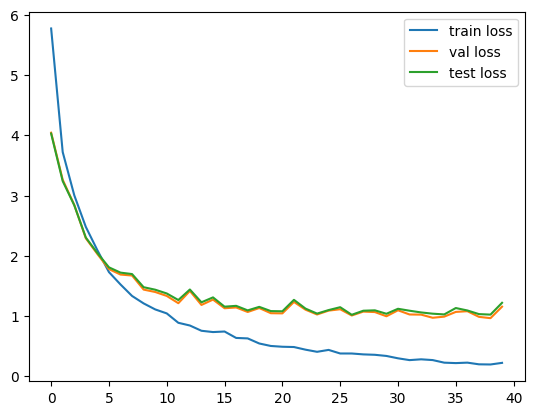

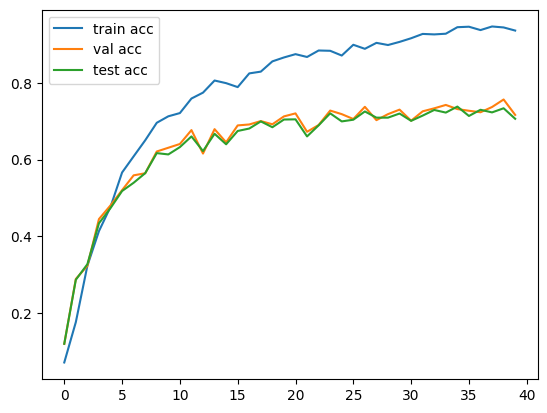

In [65]:
plots_acc_loss(vgg19_0_fitted, vgg19_split0_acc, vgg19_split0_loss)

#### split 1

In [60]:
vgg19 = VGG19(input_shape=IMG_SIZE + [3], weights="imagenet", include_top=False)

Found 4094 images belonging to 102 classes.
Found 2047 images belonging to 102 classes.
Found 2048 images belonging to 102 classes.
(None, 8, 8, 512) 512
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)      [(None, 256, 256, 3)]     0         |
|                                                               |
| block1_conv1 (Conv2D)     (None, 256, 256, 64)      1792      |
|                                                               |
| block1_conv2 (Conv2D)     (None, 256, 256, 64)      36928     |
|                                                               |
| block1_pool (MaxPooling2D)  (None, 128, 128, 64)    0         |
|                                                               |
| block2_conv1 (Conv2D)     (None,

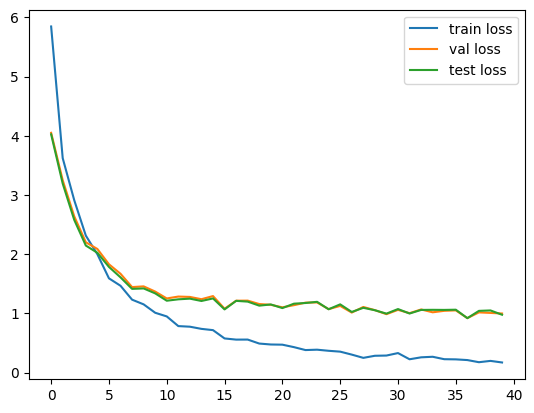

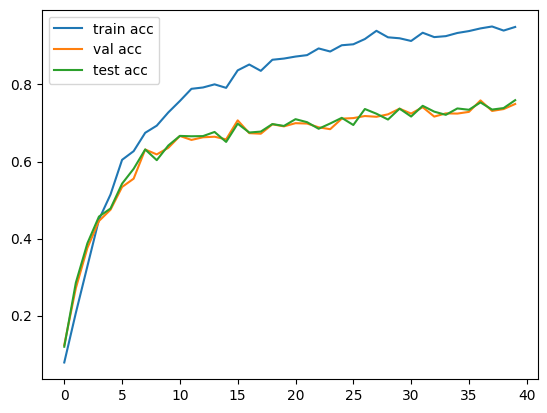

In [61]:
# metrics for the test set plots
vgg19_split1_acc = []
vgg19_split1_loss= []

# note: split_num path - change if needed!
vgg19_1_fitted = training_procedure(model_type=vgg19, split_num='/content/data_split1', acc_arr=vgg19_split1_acc, loss_arr=vgg19_split1_loss)

plots_acc_loss(vgg19_1_fitted, vgg19_split1_acc, vgg19_split1_loss)

### YOLOv5:

#### Loading yolov5

In [40]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -r requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 15814, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 15814 (delta 10), reused 26 (delta 10), pack-reused 15768
Receiving objects: 100% (15814/15814), 14.64 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (10822/10822), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.9/605.9 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00


#### **Now - PLEASE ADD the code of train_classify_freeze.py to the directory of yolov5/classify before the next cell run**
- This code is the modified classify/train.py and will be used in the rest of this notebook in order to perform transfer learning to our problem of flowers classification, using the pre-trained model of yolov5 for classification.
- I've modified the network - the last layer was changed for our problem, and added weights freezing of the backbone layers (those layers will be frozen by setting their gradients to zero before training starts)
- I've also added metrics logs in order to get the train/test/validation accuracy and cross entropy loss through the epochs that will be plotted later in graphs as a function of the number of epochs


#### plot function:

In [41]:
def plot_res_yolov(model_df):

    # loss
    plt.plot(model_df['           train_v/loss'], label='train loss')
    plt.plot(model_df['               val/loss'], label='val loss')
    plt.plot(model_df['              test/loss'], label='test loss')
    plt.legend()
    plt.show()

    # accuracies
    plt.plot(model_df['metrics/accuracy_top1_train_v'], label='train acc')
    plt.plot(model_df['metrics/accuracy_top1_val'], label='val acc')
    plt.plot(model_df['metrics/accuracy_top1_test'], label='test acc')
    plt.legend()
    plt.show()


#### split 0:

training the model using the modified training function(code)

In [ ]:
# note: change data path if needed!

In [42]:
!python classify/train_classify_freeze.py --model yolov5s-cls.pt --data /content/data_split0 --epochs 40 --img 224 --freeze 9

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/train_classify_freeze: model=yolov5s-cls.pt, data=/content/data_split0, epochs=40, batch_size=64, imgsz=224, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, freeze=[9], seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.

In [43]:
# note: change to exp# instead of exp if you run from start the yolov
#       (i.e. change the exp according to your run number of the train)
# note: change csv path if needed!

results_df0 = pd.read_csv("/content/yolov5/runs/train-cls/exp/results.csv")
results_df0

,epoch,train/loss,val/loss,test/loss,train_v/loss,metrics/accuracy_top1_val,metrics/accuracy_top5_val,metrics/accuracy_top1_test,metrics/accuracy_top5_test,metrics/accuracy_top1_train_v,metrics/accuracy_top5_train_v,lr/0
0,0,2.68310,1.4259,1.4262,1.51730,0.87005,0.97362,0.87988,0.98340,0.84612,0.96336,0.000975
1,1,1.48110,1.2482,1.2430,1.29150,0.91744,0.98681,0.92529,0.98926,0.91451,0.97851,0.000950
2,2,1.32180,1.1925,1.1867,1.21900,0.93307,0.99023,0.93555,0.99023,0.92965,0.98290,0.000926
3,3,1.24120,1.1643,1.1543,1.16890,0.94284,0.99316,0.94678,0.99268,0.94309,0.98632,0.000901
4,4,1.18700,1.1233,1.1295,1.12150,0.95164,0.99170,0.94922,0.99121,0.95823,0.98974,0.000876
5,5,1.14070,1.1097,1.1117,1.10070,0.95457,0.99511,0.95557,0.99316,0.95896,0.98999,0.000852
6,6,1.12330,1.1044,1.1040,1.08970,0.95408,0.99511,0.95410,0.99365,0.96141,0.99096,0.000827
7,7,1.11330,1.1026,1.1063,1.06380,0.95310,0.99365,0.95361,0.99072,0.96678,0.99218,0.000802
8,8,1.09620,1.1096,1.1060,1.06710,0.95066,0.99267,0.95508,0.99121,0.96727,0.99096,0.000777
9,9,1.07810,1.0908,1.0921,1.04340,0.95603,0.99463,0.95312,0.99170,0.96971,0.99316,0.000753


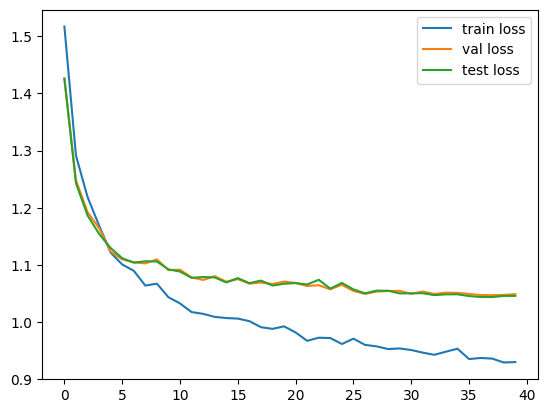

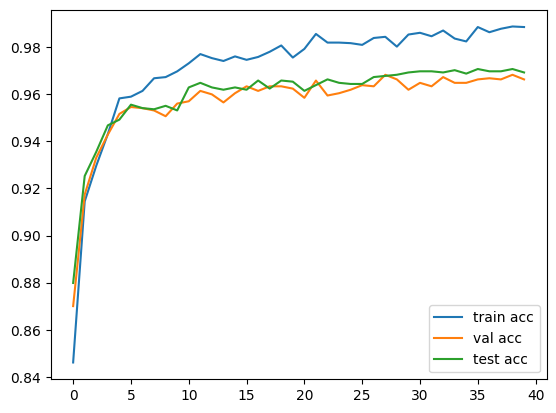

In [44]:
plot_res_yolov(results_df0)

#### split 1:

In [ ]:
# note: change data path if needed!

In [45]:
!python classify/train_classify_freeze.py --model yolov5s-cls.pt --data /content/data_split1 --epochs 40 --img 224 --freeze 9

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")

classify/train_classify_freeze: model=yolov5s-cls.pt, data=/content/data_split1, epochs=40, batch_size=64, imgsz=224, nosave=False, cache=None, device=, workers=8, project=runs/train-cls, name=exp, exist_ok=False, pretrained=True, optimizer=Adam, lr0=0.001, decay=5e-05, label_smoothing=0.1, cutoff=None, dropout=None, verbose=False, freeze=[9], seed=0, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-193-g485da42 Python-3.10.

In [46]:
# note: change to exp# instead of exp2 if you run from start the yolov
#       (i.e. change the exp according to your run number of the train)
# note: change csv path if needed!
results_df1 = pd.read_csv("/content/yolov5/runs/train-cls/exp2/results.csv")
print(results_df1.columns)
results_df1

Index(['                  epoch', '             train/loss',
       '               val/loss', '              test/loss',
       '           train_v/loss', 'metrics/accuracy_top1_val',
       'metrics/accuracy_top5_val', 'metrics/accuracy_top1_test',
       'metrics/accuracy_top5_test', 'metrics/accuracy_top1_train_v',
       'metrics/accuracy_top5_train_v', '                   lr/0'],
      dtype='object')


,epoch,train/loss,val/loss,test/loss,train_v/loss,metrics/accuracy_top1_val,metrics/accuracy_top5_val,metrics/accuracy_top1_test,metrics/accuracy_top5_test,metrics/accuracy_top1_train_v,metrics/accuracy_top5_train_v,lr/0
0,0,2.67810,1.4536,1.4496,1.51570,0.86175,0.97215,0.86426,0.97705,0.84929,0.95994,0.000975
1,1,1.46110,1.2351,1.2409,1.28890,0.93063,0.98876,0.93115,0.98975,0.91500,0.98192,0.000950
2,2,1.30300,1.1743,1.1793,1.20530,0.94333,0.99072,0.94824,0.99268,0.93820,0.98583,0.000926
3,3,1.23260,1.1511,1.1569,1.15270,0.93991,0.98828,0.94824,0.99219,0.94944,0.98803,0.000901
4,4,1.18400,1.1355,1.1317,1.12810,0.94577,0.99072,0.95361,0.99219,0.95335,0.98974,0.000876
5,5,1.15340,1.1197,1.1213,1.10220,0.94822,0.99365,0.95801,0.99219,0.95970,0.98999,0.000852
6,6,1.12440,1.1027,1.1079,1.07690,0.95506,0.99072,0.95996,0.99268,0.96434,0.99121,0.000827
7,7,1.12320,1.1048,1.1052,1.06210,0.95310,0.99365,0.95508,0.99170,0.96312,0.99243,0.000802
8,8,1.08790,1.0913,1.0972,1.04990,0.95848,0.99218,0.95703,0.99365,0.96947,0.99194,0.000777
9,9,1.09030,1.0864,1.0903,1.05200,0.95799,0.99365,0.96094,0.99219,0.96385,0.99145,0.000753


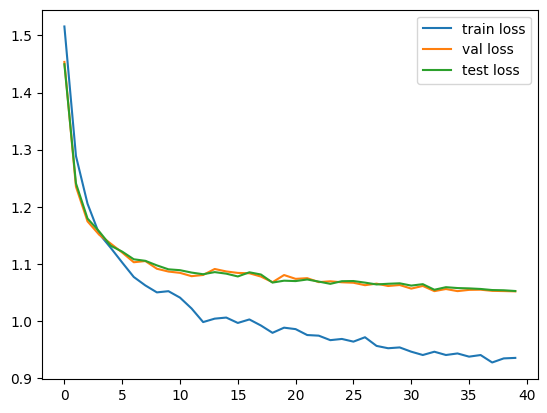

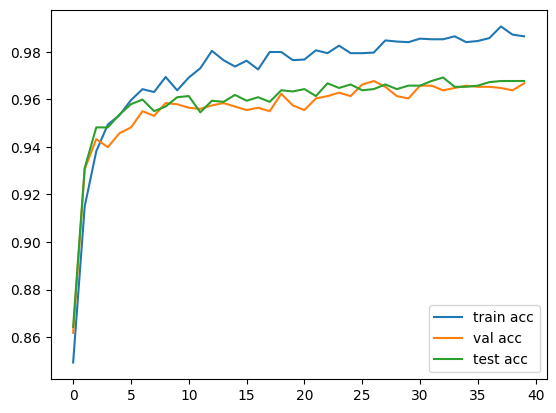

In [48]:
plot_res_yolov(results_df1)

### DenseNet 201:

In [68]:
def training_procedure_densenet(model_type, split_num, acc_arr,loss_arr ,num_classes=102):

    # Through flow_from_directory - we create an array of images that can be used for training.
    training_set = train_datagen.flow_from_directory(f'{split_num}/train',
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)
    # print('training_set_len: ', len(training_set))
    validation_set = validation_datagen.flow_from_directory(f'{split_num}/val',
                                                    target_size = (256, 256),
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

    test_set = test_datagen.flow_from_directory(f'{split_num}/test',
                                                target_size = (256, 256),
                                                batch_size = 128,
                                                class_mode = 'categorical',
                                                shuffle = False)

    # building the model:
    keras.backend.clear_session()

    for layer in model_type.layers:
        layer.trainable = False # freezing layers

    print(model_type.output_shape, model_type.output_shape[-1])
    model_to_fit = Sequential([model_type,
                               keras.layers.GlobalAveragePooling2D(),
                               Flatten(),
                               Dense(model_type.output_shape[-1],activation="relu"),
                               Dense(classes_n, activation='softmax')
                              ])

    model_to_fit.summary()

    model_to_fit.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_to_fit = model_to_fit.fit(training_set, validation_data=validation_set, epochs=40 , steps_per_epoch=50,
                                    callbacks=[customTestEpochCallback(test_set_gen=test_set, acc_arr_test=acc_arr, loss_arr_test=loss_arr)])

    return model_to_fit

In [69]:
IMG_SIZE = [image_height,image_width]

# creating a DenseNet201 model, and removing the last layer
# This will be replaced with images classes we have.
densenet201 = DenseNet201(input_shape=IMG_SIZE + [3], weights="imagenet", include_top=False)

#### split 0

Found 4094 images belonging to 102 classes.
Found 2047 images belonging to 102 classes.
Found 2048 images belonging to 102 classes.
(None, 8, 8, 1920) 1920
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1920)              3688320   
                                                                 
 dense_1 (Dense)             (None, 102)               195942    
                                

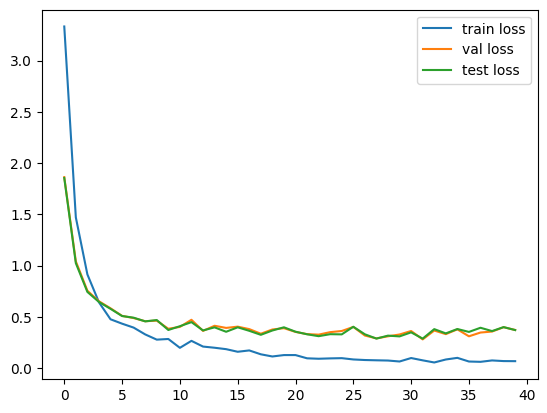

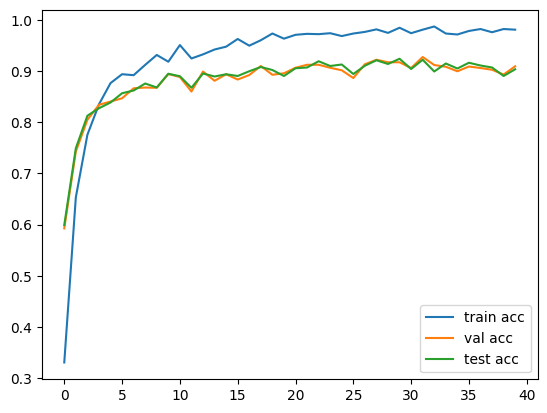

In [70]:
# metrics for the test set
densenet201_split0_acc = []
densenet201_split0_loss= []

# note: change split_num path if needed!
densenet201_0_fitted = training_procedure_densenet(model_type=densenet201, split_num='/content/data_split0',
                                          acc_arr=densenet201_split0_acc, loss_arr=densenet201_split0_loss)

plots_acc_loss(densenet201_0_fitted, acc_arr_t=densenet201_split0_acc, loss_arr_t=densenet201_split0_loss)

#### split 1

Found 4094 images belonging to 102 classes.
Found 2047 images belonging to 102 classes.
Found 2048 images belonging to 102 classes.
(None, 8, 8, 1920) 1920
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 1920)              3688320   
                                                                 
 dense_1 (Dense)             (None, 102)               195942    
                                

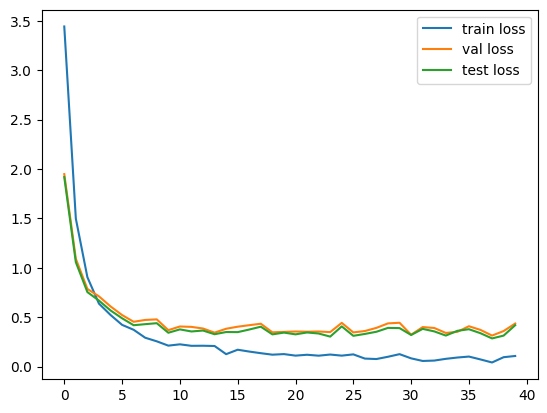

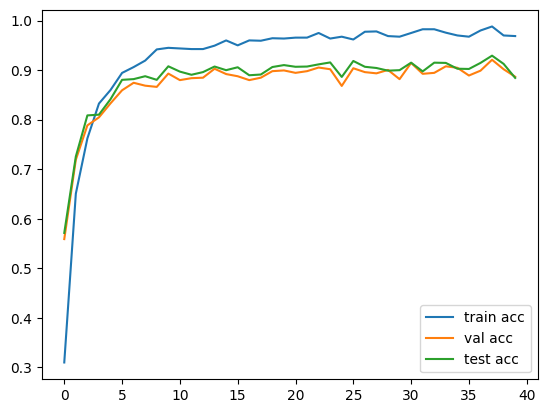

In [72]:
# metrics for the test set
densenet201_split1_acc = []
densenet201_split1_loss= []

densenet201 = DenseNet201(input_shape=IMG_SIZE + [3], weights="imagenet", include_top=False)

# note: change split_num path if needed!
densenet201_1_fitted = training_procedure_densenet(model_type=densenet201, split_num='/content/data_split1',
                                          acc_arr=densenet201_split1_acc, loss_arr=densenet201_split1_loss)

plots_acc_loss(densenet201_1_fitted, acc_arr_t=densenet201_split1_acc, loss_arr_t=densenet201_split1_loss)